## Logistic Regression Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

首先载入一个包含n个实例的简单数据集, 每个实例的格式为 {x1 x2 label}， label取值仅为 0,1，为二分类

In [8]:
def loadDataset(filepath):
    dataMat = []
    labelMat = []
    with open(filepath) as data:
        for line in data.readlines():
            arr = line.strip().split()
            dataMat.append([1.0, float(arr[0]), float(arr[1])])  # 增加了一列值为1的属性，方便后面矩阵运算
            labelMat.append(int(arr[2]))
    return dataMat, labelMat

In [10]:
def sigmoid(z):
    '''
    sigmoid 函数
    Args:
        z: 线性回归模型的预测值
    Return: sigmoid输出
    '''
    return 1.0 / (1 + np.exp(-z))

接下来定义梯度上升法更新权重 （此处为全局定步长梯度，即批量梯度上升）

In [12]:
def gradAscent(data, labels, alpha=0.001, maxIter=500):
    '''
    Args:
        data: 包含 n-d 特征的数据集
        labels: 标签集
        alpha: 步长(学习率)
        maxIter: 最大迭代次数
    Return:
        weights: 权重
    '''
    dataMat = np.mat(data)
    labelMat = np.mat(labels).transpose()  # 将label矩阵转置为列向量
    m, n = np.shape(dataMat)
    weights = np.ones((n, 1))  # 初始化权重矩阵（全零）
    for i in range(maxIter):
        y = sigmoid(dataMat*weights)  # 实质上是用线性回归模型的预测值逼近真实值的对数几率
        error = (labelMat - y)
        weights += alpha*dataMat.transpose()*error
    return weights

In [49]:
dataMat, labelMat = loadDataset('./dataset/testSet.txt')
weights = gradAscent(dataMat, labelMat)
weights

array([[ 4.12414349],
       [ 0.48007329],
       [-0.6168482 ]])

下面对分类决策边界进行可视化

In [56]:
def plotBestFit(weights):
    dataMat, labelMat = loadDataset('./dataset/testSet.txt')
    dataArr = np.array(dataMat)
    labelMat = np.array(labelMat)
    m = np.shape(dataArr)[0]
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    for i in range(m):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i, 1])
            ycord1.append(dataArr[i, 2])
        else:
            xcord2.append(dataArr[i, 1])
            ycord2.append(dataArr[i, 2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=20, c='dodgerblue', marker='s')
    ax.scatter(xcord2, ycord2, s=20, c='green')
    # 最佳拟合直线：1*w0 + w1*x1 + w2*x2 = 0
    # z = 0 时，预测值大于 0.5 为正例，反之为负例
    # 横轴为 x1, 纵轴为x2
    x = np.arange(-3.0, 3.0, 0.1)
    y = (-weights[0] - weights[1]*x) / weights[2]
    ax.plot(x, y.T)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    

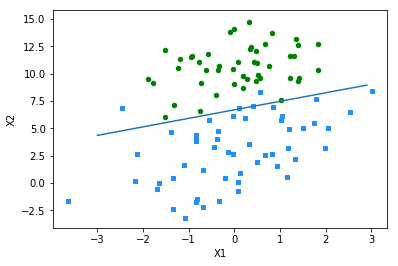

In [51]:
plotBestFit(weights)

上面的梯度上升法每次读取一整个数据集来更新权重，当数据集过大时非常耗费计算资源,收敛过程也可能振荡。因此通常采取一种随机梯度上升法，每次随机选取一个batch的数据计算梯度并更新权重

In [42]:
def stocGradAscent(data, labels, maxIter=150):
    '''
    随机梯度上升（每次迭代随机选取一个instance）
    Args:
        data: 包含 n-d 特征的数据集
        labels: 标签集
        maxIter: 最大迭代次数（以保证快速收敛）
    Returns:
        weights: 更新的权重
    '''
    data = np.mat(data)
    labesl = np.mat(labels).T
    m, n = np.shape(data)
    weights = np.ones((n,1))
    for i in range(maxIter):
        dataIndex = list(range(m))
        for j in range(m):
            # 使学习率随迭代次数增大而减小
            alpha = 4 / (1.0 + i + j) + 0.001
            # 随机选取一个实例计算梯度
            randIndex = int(np.random.uniform(0, len(dataIndex)))
            y = sigmoid(np.sum(data[randIndex] * weights))
            error = labels[randIndex] - y
            weights = weights + alpha * error * data[randIndex].T
            del(dataIndex[randIndex])
    return weights

In [52]:
dataMat, labelMat = loadDataset('./dataset/testSet.txt')
weights = stocGradAscent(dataMat, labelMat)
weights

matrix([[14.03021096],
        [ 1.0348258 ],
        [-2.03087127]])

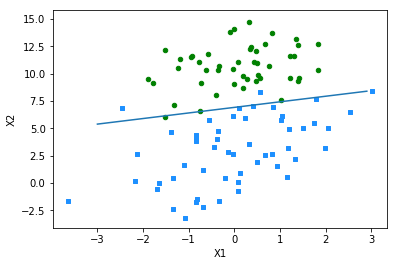

In [57]:
plotBestFit(weights)

## Example: using logistic regression to estimate horse fatalities from colic

下面是一个小例子，利用对率回归预测得疝气的马是否会死亡。数据集共 368 个 instances，每个 instance 为 28 维特征向量

首先我们需要对数据集进行预处理，主要是对缺失值的处理。通常有以下几种方式填补缺失值：
- 取特征均值
- 取特殊值，例如 -1
- 忽略属性值缺失的实例
- 取相似items的均值
- 利用其他的ML算法预测缺失值

这里采用的方法是填补特殊值 0，使得该项对应的权重系数不做更新。且通过 sigmoid 函数我们知道 z=0 时 输出值为 0.5，所以填充 0 值不会使预测结果偏倚

In [59]:
def classify(x, weights):
    '''
    二分类，以0.5为界
    Args:
        x: n-d 数据
        weights: 权重
    Return：分类结果（正负）
        
    '''
    prob = sigmoid(np.sum(x * weights))
    if prob > 0.5:
        return 1.0
    else:
        return 0.0

In [75]:
def colicTest():
    trainingSet = []
    trainingLabels = []
    # 训练
    with open('./dataset/horseColicTraining.txt') as data_train:
        for line in data_train.readlines():
            arr = line.strip().split('\t')
            arr = list(map(float, arr))
            trainingSet.append(arr[:-1])
            # 每行最后一个为label
            trainingLabels.append(arr[-1])
    trainWeights = stocGradAscent(np.array(trainingSet), trainingLabels, 500)
    # 验证
    errorCount = 0
    numTest = 0
    with open('./dataset/horseColicTest.txt') as data_test:
        for line in data_test.readlines():
            numTest += 1.0
            arr = line.strip().split('\t')
            arr = list(map(float, arr))
            testSet = arr[:-1]
            testLabel = arr[-1]
            if int(classify(testSet, trainWeights)) != int(testLabel):
                errorCount += 1
    errorRate = float(errorCount / numTest)
    print('the error rate is : %f' % errorRate)
    return errorRate
            

In [78]:
def multiTest():
    # 10次测试求错误率均值
    num = 10
    errorSum = 0.0
    for i in range(num):
        errorSum += colicTest()
    print('after %d iterations the mean error rate is %f' % (num, errorSum / float(num) ))

In [79]:
multiTest()

the error rate is : 0.373134
the error rate is : 0.417910
the error rate is : 0.253731
the error rate is : 0.298507
the error rate is : 0.373134
the error rate is : 0.373134
the error rate is : 0.283582
the error rate is : 0.268657
the error rate is : 0.388060
the error rate is : 0.298507
after 10 iterations the mean error rate is 0.332836
